In [5]:
import torch
import torch.nn as nn
import kagglehub
import os
import tarfile
from collections import OrderedDict
import pandas as pd
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
from tqdm import tqdm # For progress bars

# Scikit-learn (for our SVM)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC # Support Vector Classifier
from sklearn.metrics import accuracy_score, top_k_accuracy_score, confusion_matrix

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

import argparse

In [6]:
# --- 1. Define Paths ---
DATASET_PATH = "." # We are in the 'aml-project' directory
TRAIN_LIST_FILE = os.path.join(DATASET_PATH, "list/train.txt")
TEST_LIST_FILE = os.path.join(DATASET_PATH, "list/test.txt")
TEST_TRUTH_FILE = os.path.join(DATASET_PATH, "list/groundtruth.txt")
WITH_PAIRS_FILE = os.path.join(DATASET_PATH, "list/class_with_pairs.txt")
WITHOUT_PAIRS_FILE = os.path.join(DATASET_PATH, "list/class_without_pairs.txt")
TRAIN_IMG_DIR = DATASET_PATH
TEST_IMG_DIR = DATASET_PATH

# --- 2. Define Parameters ---
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 32
NUM_CLASSES = 100

print(f"Using device: {DEVICE}")

Using device: cuda


In [7]:
print("Building label map...")
# Load all labels from both training and test ground truth
train_labels_df = pd.read_csv(TRAIN_LIST_FILE, sep=' ', header=None)[1]
test_labels_df = pd.read_csv(TEST_TRUTH_FILE, sep=' ', header=None)[1]

# Combine them and get all unique, sorted species IDs
all_unique_species_ids = sorted(pd.concat([train_labels_df, test_labels_df]).unique())

# Create the map: {species_id: index_from_0_to_99, ...}
label_map = {species_id: i for i, species_id in enumerate(all_unique_species_ids)}
num_mapped_classes = len(label_map)

print(f"Label map created. Total unique classes found: {num_mapped_classes}")
print(f"Example mapping: ID {all_unique_species_ids[0]} -> Index {label_map[all_unique_species_ids[0]]}")

Building label map...
Label map created. Total unique classes found: 100
Example mapping: ID 12254 -> Index 0


In [ ]:
# --- 1. Get Model Path from Kaggle Hub ---
print("Downloading model files...")
model_dir = kagglehub.model_download("juliostat/dinov2_patch14_reg4_onlyclassifier_then_all/pyTorch/default")
WEIGHTS_FILE = os.path.join(model_dir, 'model_best.pth.tar')
print(f"Weights file path: {WEIGHTS_FILE}")

# --- 2. Load the CORRECT Model Architecture ---
print("Loading DINOv2 ViT-Base (vitb14_reg) architecture...")
model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14_reg', trust_repo=True)
print("Architecture loaded.")

# --- 3. Load Downloaded Kaggle Checkpoint ---
print(f"Loading weights from checkpoint: {WEIGHTS_FILE}")

# Allowlist the argparse.Namespace class
torch.serialization.add_safe_globals([argparse.Namespace])

# Now this line will work with weights_only=True
checkpoint = torch.load(WEIGHTS_FILE, map_location='cpu', weights_only=True)

# --- 4. Extract the 'state_dict' ---
if 'state_dict' in checkpoint:
    state_dict = checkpoint['state_dict']
    print("Found 'state_dict' key in checkpoint.")
else:
    raise KeyError("Checkpoint does not contain 'state_dict' key. Please inspect the file.")
    
# --- 5. Clean the Weights (Manual Fixes) ---
print("Cleaning checkpoint state_dict...")
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k.replace('module.', '')
    if name == 'reg_token':
        name = 'register_tokens'
    if 'head.' in name:
        continue
    if name == 'pos_embed':
        model_pos_embed = model.state_dict()['pos_embed']
        if v.shape != model_pos_embed.shape:
            zeros_to_add = torch.zeros(1, 1, v.shape[2])
            v = torch.cat((v, zeros_to_add), dim=1)
    new_state_dict[name] = v

# --- 6. Load Cleaned Weights into Model ---
model.load_state_dict(new_state_dict, strict=False)
print("Successfully loaded Kaggle weights into model architecture.")

# --- 7. MAKE IT A FEATURE EXTRACTOR ---
model.head = nn.Identity()
print("Replaced model.head with nn.Identity(). Model is now a feature extractor.")

# --- 8. Final Preparation ---
model.to(DEVICE)
model.eval()
print(f"Model moved to {DEVICE} and set to eval() mode.")

Weights file path: /home/wongxuanyong/.cache/kagglehub/models/juliostat/dinov2_patch14_reg4_onlyclassifier_then_all/pyTorch/default/3/model_best.pth.tar
Loading DINOv2 ViT-Base (vitb14_reg) architecture...


Using cache found in /home/wongxuanyong/.cache/torch/hub/facebookresearch_dinov2_main


Architecture loaded.
Loading weights from checkpoint: /home/wongxuanyong/.cache/kagglehub/models/juliostat/dinov2_patch14_reg4_onlyclassifier_then_all/pyTorch/default/3/model_best.pth.tar
Found 'state_dict' key in checkpoint.
Cleaning checkpoint state_dict...
Successfully loaded Kaggle weights into model architecture.
Replaced model.head with nn.Identity(). Model is now a feature extractor.
Model moved to cuda and set to eval() mode.


In [9]:
# --- 1. Define ONE Transform ---
# We use the validation transform for ALL data
# to get consistent features.
val_test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# --- 2. Modified PlantDataset ---
class PlantDataset(Dataset):
    def __init__(self, txt_file, img_dir, label_map, transform=None, is_test=False):
        self.is_test = is_test
        self.img_data = pd.read_csv(txt_file, sep=' ', header=None)
        self.img_dir = img_dir
        self.label_map = label_map # Store the map
        self.transform = transform

    def __len__(self):
        return len(self.img_data)

    def __getitem__(self, idx):
        img_name = self.img_data.iloc[idx, 0]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        if self.is_test:
            return image
        else:
            # 1. Get the original Species ID
            species_id = int(self.img_data.iloc[idx, 1])
            # 2. Convert it to the class index (0-99)
            label = self.label_map[species_id]
            return image, label

print("UPDATED Dataset class and transforms defined.")

UPDATED Dataset class and transforms defined.


In [10]:
# --- 1. Create Datasets ---
# All datasets will use the SAME transform
train_dataset = PlantDataset(txt_file=TRAIN_LIST_FILE,
                             img_dir=TRAIN_IMG_DIR,
                             label_map=label_map,
                             transform=val_test_transform)

test_dataset = PlantDataset(txt_file=TEST_LIST_FILE,
                            img_dir=TEST_IMG_DIR,
                            label_map=label_map,
                            transform=val_test_transform,
                            is_test=True)

print(f"Training data: {len(train_dataset)} samples")
print(f"Test data: {len(test_dataset)} samples")

# --- 2. Create DataLoaders ---
# shuffle=False is fine, order doesn't matter for extraction
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
print(f"DataLoaders created.")

# --- 3. Load and map ground truth labels for evaluation ---
original_test_labels = pd.read_csv(TEST_TRUTH_FILE, sep=' ', header=None).iloc[:, 1].values
y_test = np.array([label_map[label] for label in original_test_labels])
print(f"y_test (ground truth) labels loaded and mapped to [0-99].")

Training data: 4744 samples
Test data: 207 samples
DataLoaders created.
y_test (ground truth) labels loaded and mapped to [0-99].


In [11]:
def extract_features(loader, is_test=False):
    features_list = []
    labels_list = []
    
    with torch.no_grad():
        for batch in tqdm(loader, desc="Extracting features"):
            if is_test:
                images = batch.to(DEVICE)
            else:
                images, labels = batch
                images = images.to(DEVICE)
                labels_list.extend(labels.cpu().numpy())
            
            batch_features = model(images)
            features_list.extend(batch_features.cpu().numpy())
            
    return np.array(features_list), np.array(labels_list)

# --- Extract Training Features ---
print("Extracting features from TRAINING set...")
X_train_features, y_train_labels = extract_features(train_loader)
print(f"Training features shape: {X_train_features.shape}") 
print(f"Training labels shape: {y_train_labels.shape}")     

# --- Extract Test Features ---
print("\nExtracting features from TEST set...")
X_test_features, _ = extract_features(test_loader, is_test=True)
print(f"Test features shape: {X_test_features.shape}") 

# --- Save features to disk ---
print("\nSaving features to disk...")
np.save("X_train_features.npy", X_train_features)
np.save("y_train_labels.npy", y_train_labels)
np.save("X_test_features.npy", X_test_features)
np.save("y_test_truth.npy", y_test) # Save the MAPPED y_test
print("Features saved!")

Extracting features from TRAINING set...


Extracting features: 100%|██████████| 149/149 [04:04<00:00,  1.64s/it]


Training features shape: (4744, 768)
Training labels shape: (4744,)

Extracting features from TEST set...


Extracting features: 100%|██████████| 7/7 [00:13<00:00,  1.87s/it]

Test features shape: (207, 768)

Saving features to disk...
Features saved!


In [12]:
# --- Load features from disk ---
print("Loading features from disk...")
X_train = np.load("X_train_features.npy")
y_train = np.load("y_train_labels.npy")
X_test = np.load("X_test_features.npy")
y_test = np.load("y_test_truth.npy") # Load the MAPPED y_test

print(f"Loaded X_train: {X_train.shape}")
print(f"Loaded y_train: {y_train.shape}")

# --- Create and Train the ML Pipeline (SVM) ---
print("\nTraining Support Vector Classifier (SVC)...")
clf = make_pipeline(
    StandardScaler(),
    SVC(probability=True, kernel='rbf', C=1.0) # probability=True is for Top-5
)

# This is the training step!
clf.fit(X_train, y_train)

print("ML model (SVC) trained successfully!")

Loading features from disk...
Loaded X_train: (4744, 768)
Loaded y_train: (4744,)

Training Support Vector Classifier (SVC)...
ML model (SVC) trained successfully!


In [13]:
print("Evaluating SVC model on test features...")

# --- 1. Top-1 Accuracy ---
y_pred_top1 = clf.predict(X_test)
top1_acc = accuracy_score(y_test, y_pred_top1)

print(f"\n--- Top-1 Accuracy ---")
print(f"Accuracy: {top1_acc * 100:.2f}%")

# --- 2. Top-5 Accuracy ---
y_pred_probas = clf.predict_proba(X_test)
all_class_labels = np.arange(NUM_CLASSES)
top5_acc = top_k_accuracy_score(y_test, y_pred_probas, k=5, labels=all_class_labels)

print(f"\n--- Top-5 Accuracy ---")
print(f"Accuracy: {top5_acc * 100:.2f}%")

# --- 3. Final Report ---
print(f"\n--- Baseline 2 (Feature Extractor + SVM) Results ---")
print(f"Top-1 Accuracy: {top1_acc * 100:.2f}%")
print(f"Top-5 Accuracy: {top5_acc * 100:.2f}%")

Evaluating SVC model on test features...

--- Top-1 Accuracy ---
Accuracy: 64.73%

--- Top-5 Accuracy ---
Accuracy: 73.43%

--- Baseline 2 (Feature Extractor + SVM) Results ---
Top-1 Accuracy: 64.73%
Top-5 Accuracy: 73.43%


Generating confusion matrix...


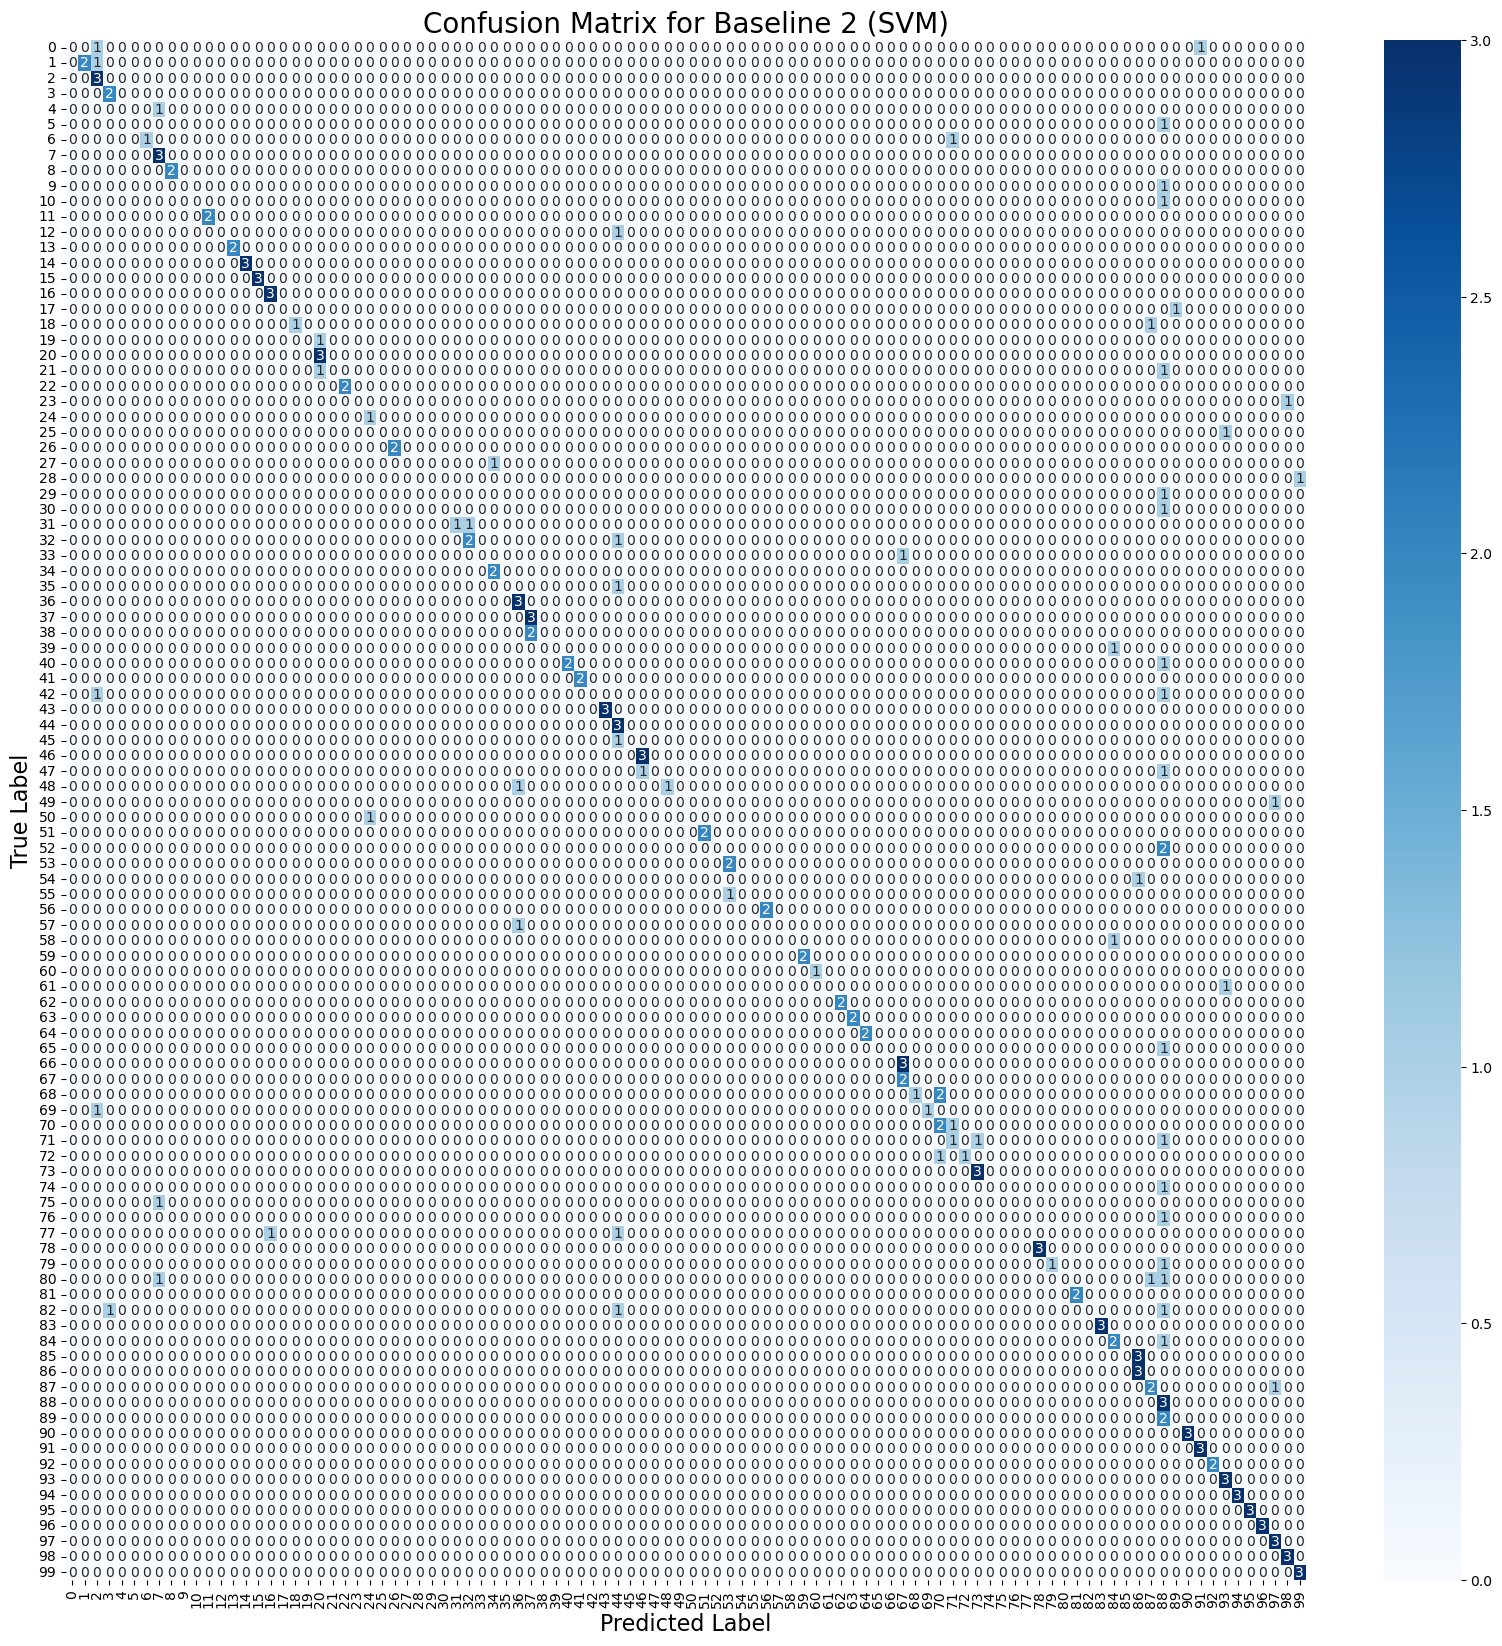

In [14]:
print("Generating confusion matrix...")
cm = confusion_matrix(y_test, y_pred_top1)

plt.figure(figsize=(20, 20))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=all_class_labels, yticklabels=all_class_labels)
plt.title('Confusion Matrix for Baseline 2 (SVM)', fontsize=20)
plt.ylabel('True Label', fontsize=16)
plt.xlabel('Predicted Label', fontsize=16)
plt.show()

In [15]:
print("--- Analysis of Performance by Class Type ---")

# 1. Load original Species ID lists
with_pairs_ids = set(pd.read_csv(WITH_PAIRS_FILE, header=None).iloc[:, 0])
without_pairs_ids = set(pd.read_csv(WITHOUT_PAIRS_FILE, header=None).iloc[:, 0])

# 2. Map Species IDs to our new Class Indices (0-99)
with_pairs_set = {label_map.get(id, -1) for id in with_pairs_ids}
without_pairs_set = {label_map.get(id, -1) for id in without_pairs_ids}
print(f"Loaded and mapped 'with pairs'/'without pairs' class indices.")

# 3. Filter Test Results
test_with_pairs_indices = [i for i, label in enumerate(y_test) if label in with_pairs_set]
test_without_pairs_indices = [i for i, label in enumerate(y_test) if label in without_pairs_set]
print(f"Found {len(test_with_pairs_indices)} 'with pairs' samples and {len(test_without_pairs_indices)} 'without pairs' samples.")

# 4. Create Filtered Arrays
y_test_with_pairs = y_test[test_with_pairs_indices]
y_pred_top1_with_pairs = y_pred_top1[test_with_pairs_indices]
y_probas_with_pairs = y_pred_probas[test_with_pairs_indices]

y_test_without_pairs = y_test[test_without_pairs_indices]
y_pred_top1_without_pairs = y_pred_top1[test_without_pairs_indices]
y_probas_without_pairs = y_pred_probas[test_without_pairs_indices]

# 5. Calculate Accuracy
acc_top1_with = accuracy_score(y_test_with_pairs, y_pred_top1_with_pairs)
acc_top5_with = top_k_accuracy_score(y_test_with_pairs, y_probas_with_pairs, k=5, labels=all_class_labels)

acc_top1_without = accuracy_score(y_test_without_pairs, y_pred_top1_without_pairs)
acc_top5_without = top_k_accuracy_score(y_test_without_pairs, y_probas_without_pairs, k=5, labels=all_class_labels)

# 6. Print Comparison
print(f"\nGroup: WITH PAIRS (Trained on Herbarium + Field)")
print(f"  Top-1 Accuracy: {acc_top1_with * 100:.2f}%")
print(f"  Top-5 Accuracy: {acc_top5_with * 100:.2f}%")

print(f"\nGroup: WITHOUT PAIRS (Trained on Herbarium ONLY)")
print(f"  Top-1 Accuracy: {acc_top1_without * 100:.2f}%")
print(f"  Top-5 Accuracy: {acc_top5_without * 100:.2f}%")

--- Analysis of Performance by Class Type ---
Loaded and mapped 'with pairs'/'without pairs' class indices.
Found 153 'with pairs' samples and 54 'without pairs' samples.

Group: WITH PAIRS (Trained on Herbarium + Field)
  Top-1 Accuracy: 86.27%
  Top-5 Accuracy: 96.08%

Group: WITHOUT PAIRS (Trained on Herbarium ONLY)
  Top-1 Accuracy: 3.70%
  Top-5 Accuracy: 9.26%


/home/wongxuanyong/miniconda3/envs/aml_project/lib/python3.10/site-packages/sklearn/metrics/_classification.py:98: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  type_true = type_of_target(y_true, input_name="y_true")
/home/wongxuanyong/miniconda3/envs/aml_project/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1998: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  y_type = type_of_target(y_true, input_name="y_true")
